In [1]:
# boilerplate

import numpy as np
import pandas as pd

from math import *
import time
import datetime
import glob

import matplotlib.pyplot as plt
from matplotlib import pylab
import matplotlib.transforms as mtransforms

get_ipython().magic(u'matplotlib inline')
#%pylab inline

In [2]:
# FIXME: Change sid and eid such that 
# sid is the first hour of a week and
# eid is the last hour of a week

numperiods = 24 # Number of periods per day
monthperiod = 30*24 # NUmber of month per day

week_id = 12

# sid = week_id*7*24-1
# eid = (week_id+1)*7*24
# # Summer
# sid=3192-2
# eid=3192+7*24-2

# Winter
sid=48 +7*24*2
eid=48+7*24 +7*24*2



firstday = 0 # i.e. Monday
daylbl = ['Sun.','Mon.', 'Tue.', 'Wed.', 'Thu.', 'Fri.', 'Sat.']
day_labels = daylbl[firstday:] + daylbl[:firstday]
firstmonth = 0 # i.e. Monday
monthlbl = ['Jan','Feb', 'Mar', 'Apl', 'May', 'June', 'July','Aug','Sep','Oct','Nov','Dec']
month_labels = monthlbl[firstmonth:] + monthlbl[:firstmonth]

In [3]:
def plotPolicies(datause, database, dataop, datampc, datarl, dataolc,scenario):
    global sid, eid, max_charge_power
    rl_policy = datarl['Action'][sid:eid]
    base_policy = database['Base_Action'][sid:eid]
    op_policy = dataop['Best_Action'][sid:eid]
    mpc_policy = datampc['Action'][sid:eid]
    olc_policy = dataolc['Action'][sid:eid]  
    time = database['Hour'][sid:eid]
    p_solar_output = datause['AC'][sid:eid]   # FIXME: set it to the predicted solar output
    p_home_load = datause['use'][sid:eid]   # FIXME: set it to the predicted home load
    
    fig, ax = plt.subplots()
    
#     ax.plot(time, base_policy, 'b--', label="RBC")
#     ax.plot(time, mpc_policy, 'c',label="MPC")
#     ax.plot(time, op_policy, 'm-.', label="Optimal")
#     ax.plot(time, p_solar_output, 'g--', label="PV output (kW)")
#     ax.plot(time, p_home_load, 'k:', label="Home load (kW)")
  
    
    
    ax.plot(time, rl_policy, 'b:',label="RL")
    ax.plot(time, base_policy,'g', label="RBC")
    ax.plot(time, mpc_policy, 'r--',label="MPC")
    ax.plot(time, olc_policy,'-.',label="DLC")
#     ax.plot(time, op_policy, label="Optimal")
#     ax.plot(time, p_solar_output, '--', label="PV output (kW)")
#     ax.plot(time, p_home_load, '-.', label="Home load (kW)",color='grey')
    #ax.legend(loc=2, borderaxespad=0., bbox_to_anchor=(.00, 1.00), fontsize = '20')
    ax.legend(loc='lower left', borderaxespad=0., fontsize = '30')
    
    
    trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
    for i in range(168+sid+24,168+eid-24,24):
        #ax.axvspan(i, i+7, alpha=0.2, color='green')
        ax.axvspan(i+7, i+11, alpha=0.15, color='red')
        ax.axvspan(i+11, i+17, alpha=0.15, color='yellow')
        ax.axvspan(i+17, i+19, alpha=0.15, color='red')
        #ax.axvspan(i+19, i+24, alpha=0.5, color='green')
    #ax.fill_between(x, 0, 1, where=y < -theta, facecolor='red', alpha=0.5, transform=trans)
    ax.set_xticks(np.arange(sid+168, eid+168, numperiods/2), minor=False)
    ax.set_xbound(lower = 168+sid, upper = 168+eid-1)
    ax.set_ybound(lower = -max_charge_power, upper = max(max_charge_power, max(p_solar_output), max(p_home_load)) )
    ax.grid(which='major', axis='x', linestyle=':')
    col_label = []
    for i in range(len(day_labels)):
        col_label.append(day_labels[i])
        col_label.append(" ")
            
    ax.set_xticklabels(col_label, rotation=0,)
    plt.yticks([-2,0,2],("-2","0","2"))

    #ax.set_title("Policies, Home Load and PV Output")
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(30)
    plt.ylim(-2.1,2.1)
    plt.savefig('bill_curve/871_{}_policy.png'.format(scenario),bbox_inches = "tight")
    plt.show()
    plt.clf()
    plt.cla()
    plt.close()
    
def plotBills(table,net_table,scenario):
    Best_Bill=table['Best_Bill']
    Base_Bill=table['Base_Bill']
    Net_Bill=net_table['Base_Bill']
    Hour=table['Hour']
    fig, ax = plt.subplots()
    ax.plot(Hour, Best_Bill,label="DDPG / export tariff = 0.1")
    ax.plot(Hour, Base_Bill,label="Baseline / export tariff = 0.1")
    ax.plot(Hour, Net_Bill,label="DDPG / export tariff = TOU")
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.legend(bbox_to_anchor=(0.22, 1), loc=1, borderaxespad=0.,prop={'size': 20})
    ax.set_ylabel('Electricity Bill ($)')
    ax.set_xticks(np.arange(0, 8639, monthperiod/2), minor=False)
    ax.set_xbound(lower = 0, upper = 8639-1)
    col_label = []
    for i in range(len(month_labels)):
        col_label.append(month_labels[i])
        col_label.append(" ")
            
    ax.set_xticklabels(col_label)
    #ax.set_title("Net metering baseline, FIT baseline and FIT DDPG")
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(26)
    plt.savefig('86_results/871_{}_bill_week2.png'.format(scenario))
    plt.show()
    plt.clf()
    plt.cla()
    plt.close()

sb4b64


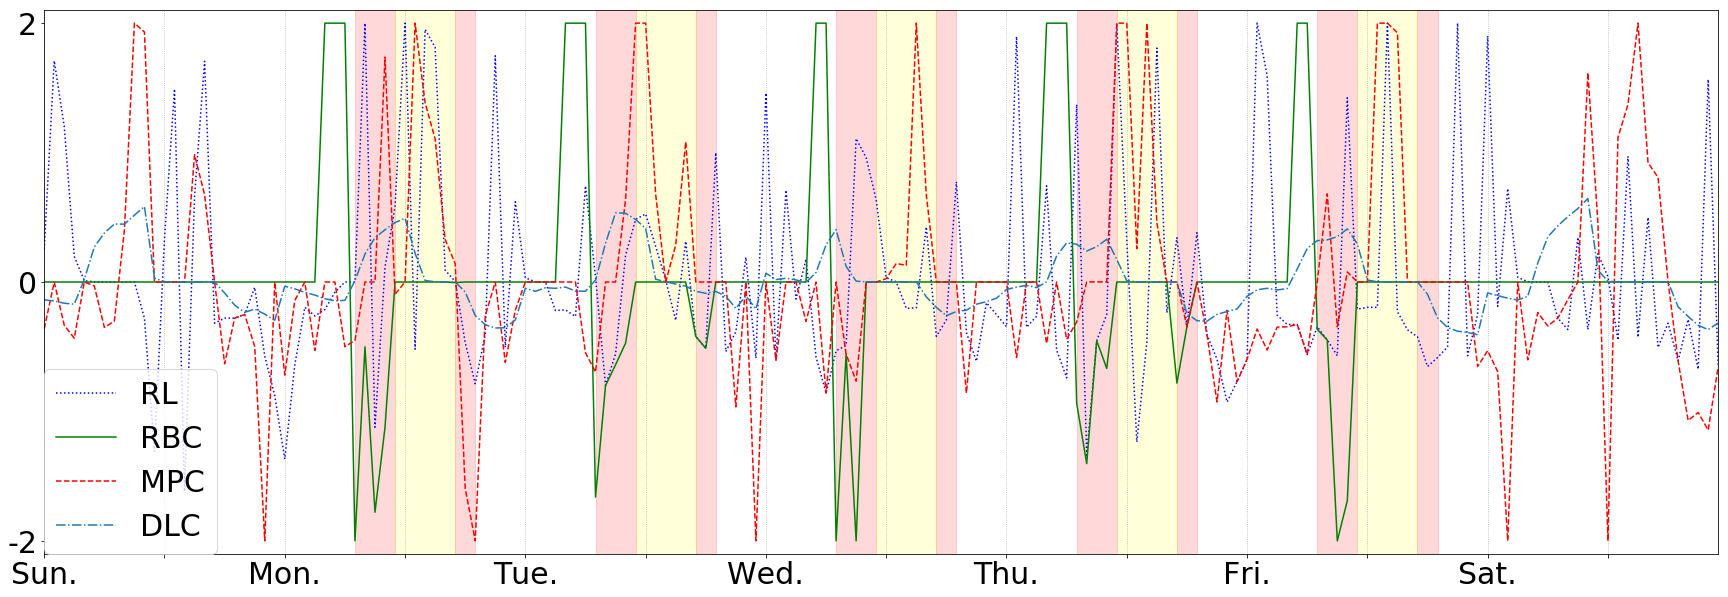

In [4]:
#scenarios=["sb4b64","sb4b135","sb8b64","sb8b135","sb10b64","sb10b135","sb20b64","sb20b135"]
scenarios=["sb4b64"]
for s in scenarios:
    ns =s[0:2]+'-'+s[2:]
    pylab.rcParams['figure.figsize'] = (30.0, 10.0)
    tableuse = pd.read_csv('data_filled2/processed_hhdata_871_2.csv')[168:8736]
    tablebase = pd.read_csv('rbc_2/871_2_rbc/{}.csv'.format(s))[168:8736]
    tableop = pd.read_csv('op_2/871_2_op/{}.csv'.format(ns))[0:8568]
    tablerl = pd.read_csv('rl_2_bill/871_2_pre2_bill/{}.csv'.format(s))[0:8568]
    tablempc = pd.read_csv('mpc_2_bill/871_2_mpc_bill/{}.csv'.format(s))[0:8568]
    tableolc = pd.read_csv('olc_2_bill/871_2_olc_bill/{}.csv'.format(s))[0:8568]
    print(s)
    if s.split("b")[2] == "135":
        max_charge_power = 5
    else:
        max_charge_power = 2

    plotPolicies(tableuse, tablebase, tableop, tablempc,tablerl,tableolc, s)
#plotBills(table,table2,scenario)

In [5]:
# PAR_Base=Base_Grid.max()/np.mean(Base_Grid)
# PAR_Base

In [6]:
# PAR_Base=Base_Grid.max()/np.mean(Base_Grid)
# PAR_Best